<a id='top'></a>
# Investigation of COVID-19 Clinical Trial Metadata
#### SOURCE: [clinicaltrials.gov](https://clinicaltrials.gov/ct2/results?cond=COVID-19)
Data downloaded January 22, 2021, on which 4,542 studies were returned on a search for 'COVID-19'.

#### CONTENTS:
- **01.** [Data Ingestion](#section1)
- **02.** [Exploratory Data Analysis (EDA)](#section2)
- **03.** [Modeling](#section3)
- **04.** [Conclusion](#section4)
    
#### QUESTIONS:
- What are some potential uses for the densely populated text fields (e.g. detailed_description)?
- How many people are currently enrolled in COVID-19 studies?
- How many COVID-19 studies have been completed to date?
- Can we predict enrollment numbers for COVID-19 studies? If not, what can we potentially predict?

In [1]:
import os
import csv
import json

import xmltodict
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [2]:
XML_DATA_DIR = './xml-data/COVID-19-search-result-ct-gov'
TXT_DATA_DIR = './txt-data/COVID-19-clinical-trials-text'
CSV_DATA_DIR = './csv-data/COVID-19-clinical-trials-csv'

<a id='section1'></a>
## 01. Data Ingestion

In [3]:
def xml_to_txt(in_path, out_path):
    """Converts .xml files to .txt files for preprocessing.
    Args:
        XML_DATA_DIR (path) : location of .xml input files
        TXT_DATA_DIR (path) : location of .txt output files
    """
    for root, dirs, in_files in os.walk(in_path):
        for in_file in tqdm(in_files):

            out_file = in_file.split('.')[0] + '.txt'
            with open(f'{in_path}/{in_file}', 'r') as i:
                tree = ET.parse(i)
                root = tree.getroot()
            i.close()

            with open(f'{out_path}/{out_file}', 'w') as o:
                for child in root:
                    o.write(child.tag + ' ' + child.text + '\n')
                    for grandchild in child:
                        o.write(grandchild.tag + ' ' + grandchild.text + '\n')
            o.close()
    return

In [4]:
xml_to_txt(XML_DATA_DIR, TXT_DATA_DIR)

100%|██████████| 4542/4542 [00:02<00:00, 1621.77it/s]


In [5]:
# Examine one of the newly created text files
!cat txt-data/COVID-19-clinical-trials-text/NCT00571389.txt

required_header 
    
download_date ClinicalTrials.gov processed this data on January 22, 2021
link_text Link to the current ClinicalTrials.gov record.
url https://clinicaltrials.gov/show/NCT00571389
id_info 
    
org_study_id BioCytics 0001
secondary_id WIRB Protocol # 20070969
nct_id NCT00571389
brief_title Isolation and Culture of Immune Cells and Circulating Tumor Cells From Peripheral Blood and Leukapheresis Products
official_title A Study to Facilitate Development of an Ex-Vivo Device Platform for Circulating Tumor Cell and Immune Cell Harvesting, Banking, and Apoptosis-Viability Assay
sponsors 
    
lead_sponsor 
      
source BioCytics, Inc.
oversight_info 
    
has_dmc Yes
brief_summary 
    
textblock 
      Primary Objective:

      This is a study to investigate the feasibility of harvesting, expanding in culture, and
      freezing circulating tumor cells and immune cells from cancer patients and healthy
      volunteers.
    
overall_status Recruiting
start_date November 

#### Unit tests for JSON parsing

In [6]:
with open('./xml-data/COVID-19-search-result-ct-gov/NCT00571389.xml') as test:
    xml_dict = json.dumps(xmltodict.parse(test.read()), indent=4)
    json_dict = json.loads(xml_dict)
    print(json_dict)

{'clinical_study': {'@rank': '4341', 'required_header': {'download_date': 'ClinicalTrials.gov processed this data on January 22, 2021', 'link_text': 'Link to the current ClinicalTrials.gov record.', 'url': 'https://clinicaltrials.gov/show/NCT00571389'}, 'id_info': {'org_study_id': 'BioCytics 0001', 'secondary_id': 'WIRB Protocol # 20070969', 'nct_id': 'NCT00571389'}, 'brief_title': 'Isolation and Culture of Immune Cells and Circulating Tumor Cells From Peripheral Blood and Leukapheresis Products', 'official_title': 'A Study to Facilitate Development of an Ex-Vivo Device Platform for Circulating Tumor Cell and Immune Cell Harvesting, Banking, and Apoptosis-Viability Assay', 'sponsors': {'lead_sponsor': {'agency': 'BioCytics, Inc.', 'agency_class': 'Industry'}}, 'source': 'BioCytics, Inc.', 'oversight_info': {'has_dmc': 'Yes'}, 'brief_summary': {'textblock': 'Primary Objective:\r\n\r\n      This is a study to investigate the feasibility of harvesting, expanding in culture, and\r\n      f

In [7]:
df = pd.json_normalize(json_dict['clinical_study'])
df.to_csv('test.csv')
df

,@rank,brief_title,official_title,source,overall_status,start_date,study_type,has_expanded_access,condition,biospec_retention,...,location.investigator.role,location_countries.country,link.url,link.description,study_first_posted.@type,study_first_posted.#text,last_update_posted.@type,last_update_posted.#text,responsible_party.responsible_party_type,condition_browse.mesh_term
0,4341,Isolation and Culture of Immune Cells and Circ...,A Study to Facilitate Development of an Ex-Viv...,"BioCytics, Inc.",Recruiting,November 2007,Observational,No,"[Solid Tumor, Adult, Healthy Donors, COVID-19 ...",Samples With DNA,...,Sub-Investigator,United States,http://www.carolinabiooncology.org,Related Info,Estimate,"December 12, 2007",Actual,"September 10, 2020",Sponsor,"Neoplastic Cells, Circulating"


In [8]:
def xml_to_csv(in_path, out_path):
    """Converts .xml files to .csv files for downstream merger step.
    Args:
        in_path  (str) : location of .xml input files
        out_path (str) : location of .csv output files
    """
    for root, dirs, in_files in os.walk(in_path):
        for in_file in tqdm(in_files):
            out_file = in_file.split('.')[0] + '.csv'
            with open(f'{in_path}/{in_file}', 'r') as i:
                xml_dict = json.dumps(xmltodict.parse(i.read()))
                json_dict = json.loads(xml_dict)
            
            df = pd.json_normalize(json_dict['clinical_study'])
            df.to_csv(f'{out_path}/{out_file}')
    return

In [9]:
xml_to_csv(XML_DATA_DIR, CSV_DATA_DIR)

100%|██████████| 4542/4542 [00:33<00:00, 135.54it/s]


In [10]:
def merge_csv_records(csv_path):
    """Combines all .csv files for downstream EDA and modeling.
    Args:
        csv_path (str) : location of .csv files to be combined
    """
    data_frames = []
    out_file = 'covid-19-clinical-trials-master.csv'
    
    for root, dirs, in_files in os.walk(csv_path):
        for in_file in tqdm(in_files):
            df = pd.read_csv(f'{csv_path}/{in_file}')
            data_frames.append(df)

    final_df = pd.concat(data_frames)
    final_df.to_csv(f'{CSV_DATA_DIR}/{out_file}')

In [11]:
%%time
merge_csv_records(CSV_DATA_DIR)

100%|██████████| 4542/4542 [00:26<00:00, 169.95it/s]
0it [00:00, ?it/s]


CPU times: user 50.5 s, sys: 847 ms, total: 51.3 s
Wall time: 51 s


Combining the 4542 .csv files results in a 42MB final output file, or roughly 1MB of text data per record.

In [12]:
!ls -lh csv-data/COVID-19-clinical-trials-csv/covid*

-rw-r--r--  1 davale  staff    42M Jan 26 16:58 csv-data/COVID-19-clinical-trials-csv/covid-19-clinical-trials-master.csv


#### [**BACK TO TOP**](#top)

<a id='section2'></a>
## 02. Exploratory Data Analysis (EDA)
#### REFERENCE: [clinicaltrials.gov](https://clinicaltrials.gov/ct2/resources/trends)

In [13]:
master_df = pd.read_csv(f'{CSV_DATA_DIR}/covid-19-clinical-trials-master.csv', low_memory=False)
master_df.head(3)

,Unnamed: 0,Unnamed: 0.1,@rank,brief_title,acronym,official_title,source,overall_status,phase,study_type,...,clinical_results.reported_events.other_events.category_list.category.title,clinical_results.reported_events.other_events.category_list.category.event_list.event.sub_title,clinical_results.reported_events.other_events.category_list.category.event_list.event.counts,clinical_results.limitations_and_caveats,id_info.nct_alias,clinical_results.baseline.population,clinical_results.participant_flow.period_list.period,clinical_results.reported_events.other_events.category_list.category.event_list.event.counts.@group_id,clinical_results.reported_events.other_events.category_list.category.event_list.event.counts.@subjects_affected,clinical_results.reported_events.other_events.category_list.category.event_list.event.counts.@subjects_at_risk
0,0,0,44,Comparison of Two Doses of Enoxaparin for Thro...,X-Covid 19,Enoxaparin for Thromboprophylaxis in Hospitali...,Niguarda Hospital,Recruiting,Phase 3,Interventional,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,3835,Remote COVID-19 Symptom Tracking for Cancer Pa...,NaN,Remote COVID-19 Symptom Tracking and Improved ...,University of Utah,Enrolling by invitation,NaN,Interventional,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1294,Myeloid Cells in Patients With Covid-19 Pneumonia,MyeloidCovid,Myeloid Cells in Patients With Covid-19 Pneumonia,Assistance Publique - Hôpitaux de Paris,Not yet recruiting,NaN,Interventional,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# N studies as of 2021-01-22
n_studies = len(master_df)
n_studies

4542

In [15]:
# Categorical aggregations of interest
agg_cols = [
    'overall_status', 
    'phase', 
    'study_type', 
    'intervention.intervention_type', 
    'enrollment.@type', 
    'eligibility.gender',
    'eligibility.healthy_volunteers',
    'study_design_info.primary_purpose'
]

for col in agg_cols:
    agg_df = master_df.astype(str).groupby(col).size()
    print(agg_df, '\n')

overall_status
Active, not recruiting      354
Approved for marketing        2
Available                    24
Completed                   663
Enrolling by invitation     152
No longer available           5
Not yet recruiting          913
Recruiting                 2280
Suspended                    23
Terminated                   47
Withdrawn                    79
dtype: int64 

phase
Early Phase 1        39
Phase 1             192
Phase 1/Phase 2     158
Phase 2             604
Phase 2/Phase 3     174
Phase 3             388
Phase 4             118
nan                2869
dtype: int64 

study_type
Expanded Access                       31
Interventional                      2566
Observational                       1681
Observational [Patient Registry]     264
dtype: int64 

intervention.intervention_type
Behavioral              159
Biological              209
Combination Product      12
Device                  165
Diagnostic Test         338
Dietary Supplement       34
Drug            

Categorical features are potential targets for classification models. For best performance we should choose one which is relatively balanced and has relatively few null values.

In [16]:
# Compute a statistic of interest
status_col = master_df['overall_status']
n_completed = len(master_df[status_col == 'Completed'])
study_completion_pct = n_completed / n_studies
print(f'{n_completed} of the {n_studies} ({study_completion_pct:.2%}) ' \
       'studies in this dataset have already been completed.')

663 of the 4542 (14.60%) studies in this dataset have already been completed.


In [17]:
# Examine study volume and enrollment over time
# NOTE: '*' cols depend on '<col>.@type' : 'Actual', 'Anticipated', etc.)
# NOTE: '~' cols may contain more than one date as a list (process later)
date_cols = [
    'verification_date', 
    'study_first_submitted', 
    'study_first_submitted_qc',
    'last_update_submitted',
    'last_update_submitted_qc',
    'start_date.#text',              # *
    'completion_date.#text',         # *
    'primary_completion_date.#text', # *
    'study_first_posted.#text',      # *
    'last_update_posted.#text',      # *
    #'pending_results.submitted',    # ~
    #'pending_results.returned'      # ~
]

for col in date_cols:
    # Overwrite string dates with pandas datetimes
    master_df[col] = pd.to_datetime(master_df[col])

In [18]:
master_df[date_cols].head()

,verification_date,study_first_submitted,study_first_submitted_qc,last_update_submitted,last_update_submitted_qc,start_date.#text,completion_date.#text,primary_completion_date.#text,study_first_posted.#text,last_update_posted.#text
0,2021-01-01,2020-04-24,2020-04-27,2021-01-11,2021-01-11,2020-05-14,2021-11-01,2021-08-01,2020-04-29,2021-01-13
1,2020-07-01,2020-06-26,2020-07-08,2020-07-08,2020-07-08,2020-04-21,2021-05-31,2021-03-31,2020-07-09,2020-07-09
2,2020-10-01,2020-10-15,2020-10-15,2020-10-15,2020-10-15,2020-11-01,2023-11-01,2022-11-01,2020-10-19,2020-10-19
3,2020-10-01,2020-09-03,2020-09-03,2020-10-14,2020-10-14,2020-11-01,2021-09-30,2021-09-30,2020-09-07,2020-10-19
4,2020-10-06,2020-04-03,2020-04-03,2020-10-07,2020-10-07,2020-08-26,2022-03-31,2022-03-31,2020-04-06,2020-10-08


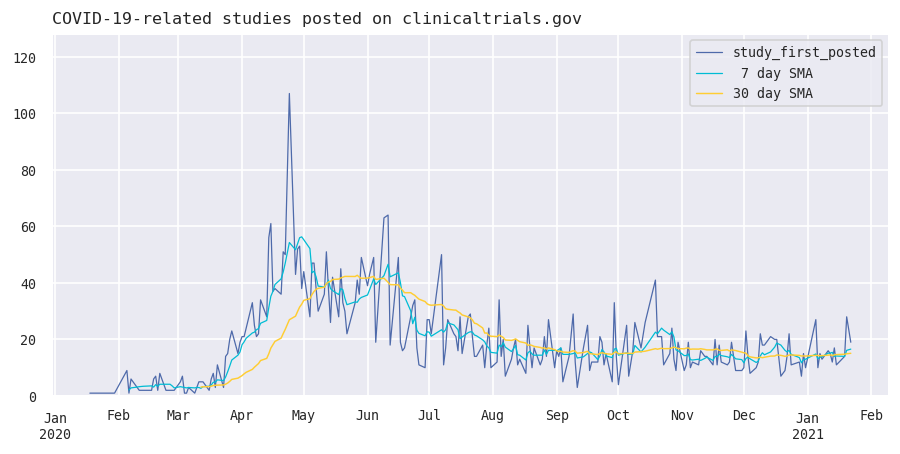

In [19]:
# Plot study volume over time
sns.set()
plt.rcParams['font.family'] = 'monospace'
fig, ax = plt.subplots(figsize=(9,4), dpi=120)

posted_col = master_df['study_first_posted.#text']
posted_dates_2020 = master_df[posted_col.dt.year >= 2020]
posted_dates_2020_counts = \
    posted_dates_2020.groupby('study_first_posted.#text').size()

sma_posted_7  = posted_dates_2020_counts.rolling(window=7).mean()
sma_posted_30 = posted_dates_2020_counts.rolling(window=30).mean()

ax.set_title(
    'COVID-19-related studies posted on clinicaltrials.gov', 
    fontsize=10, loc='left'
)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
ax.grid(True, which='minor')

ax.plot(
    posted_dates_2020_counts, 
    label='study_first_posted', 
    linewidth=0.75, linestyle='-', color='#4E6AAA'
)
ax.plot(
    sma_posted_7, 
    label=' 7 day SMA', 
    linewidth=0.75, linestyle='-', color='#00BCD4'
)
ax.plot(
    sma_posted_30, 
    label='30 day SMA', 
    linewidth=0.88, linestyle='-', color='#FFCD33'
)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.legend(loc='upper right', fontsize=8)
plt.margins(0.05, 0.2)
plt.ylim(bottom=0)
plt.show()

In [20]:
# Examine actual enrollment numbers and convert to int
enrollment_type_col = master_df['enrollment.@type']
enrolled_df = master_df[enrollment_type_col == 'Actual'].copy()
enrolled_df['enrollment.#text'] = enrolled_df['enrollment.#text'].astype(int)
enrolled_df['enrollment.#text'].describe().apply(lambda x: f'{x:.5f}')

count       1007.00000
mean       23643.07249
std       384242.32478
min            0.00000
25%           35.00000
50%          114.00000
75%          393.00000
max      7882471.00000
Name: enrollment.#text, dtype: object

One trial appears to have 7.88 million subjects enrolled. We'll definitely want to investigate that particular study more.

In [21]:
# Compute percentage of trials with patients enrolled
pct_trials_with_pts = len(enrolled_df) / len(master_df)
print(f'Studies with patients enrolled: {pct_trials_with_pts:.2%}')

Studies with patients enrolled: 22.17%


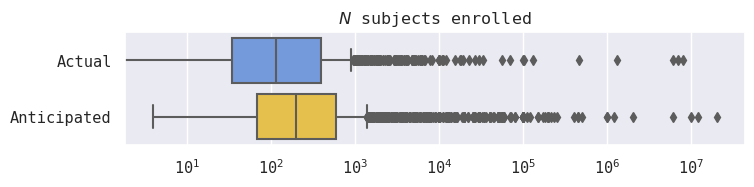

In [22]:
# Visualize actual v. anticipated enrollment
enrollment_cats = ['Actual', 'Anticipated']
master_df['enrollment.@type'] = \
    pd.Categorical(master_df['enrollment.@type'], categories=enrollment_cats)

fig, ax = plt.subplots(figsize=(8,1.5), dpi=100)
ax = sns.boxplot(
    x='enrollment.#text', 
    y='enrollment.@type', 
    data=master_df,
    palette=['#6495ED', '#FFCD33']
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set(xscale='log')
ax.set_title('$\mathit{N}$' + ' subjects enrolled')
plt.show()

#### Boxplot observations:
 - The median (p50) of actual enrolled subjects is around 100 per study
 - Anticipated enrollment is generally overestimated (could quantify this)
 - Distribution is highly skewed with a long right tail of outliers (could measure this)
 - Attempting to predict enrollment numbers is **NOT** a reasonable machine learning task given such high variance

#### [**BACK TO TOP**](#top)

<a id='section3'></a>
## 03. Modeling

- In this example we will use a combination of categorical and numerical features to predict ```study_type```.
- Some feature engineering will be required to generate meaningful numeric features from date columns.
- Special care should be taken not to include features which could be potential sources of bias.
- Features that could potentially bias our model include gender eligibility, investigator names, etc.
- Good performance will also require features which are not highly correlated.

In [23]:
# Select categorical features first, replacing NaNs with empty strings
model_cols = [
    'overall_status', 
    'eligibility.healthy_volunteers'
]

model_df = master_df[model_cols].copy()
model_df['enrollment_type'] = master_df['enrollment.@type'].astype(str)
model_df = model_df.replace(np.nan, '', regex=True)

In [24]:
# Date feature engineering 
model_df['days_posted_delta']   = (master_df['last_update_posted.#text'] - master_df['study_first_posted.#text']).dt.days
model_df['days_verified_delta'] = (master_df['last_update_submitted'] - master_df['verification_date']).dt.days

In [25]:
# Handle nulls for this numeric column
model_df['enrollment_count'] = master_df['enrollment.#text']
model_df['enrollment_count'] = model_df['enrollment_count'].replace(np.nan, 0.0, regex=True)

In [26]:
# Add the predictive target column last
model_df['study_type'] = master_df['study_type']

In [27]:
model_df.head()

,overall_status,eligibility.healthy_volunteers,enrollment_type,days_posted_delta,days_verified_delta,enrollment_count,study_type
0,Recruiting,No,Anticipated,259,10,2712.0,Interventional
1,Enrolling by invitation,No,Anticipated,0,7,300.0,Interventional
2,Not yet recruiting,Accepts Healthy Volunteers,Anticipated,0,14,120.0,Interventional
3,Recruiting,No,Anticipated,42,13,15.0,Interventional
4,Recruiting,Accepts Healthy Volunteers,Anticipated,185,1,15000.0,Observational


In [28]:
# Validate type conversions
model_df.dtypes

overall_status                     object
eligibility.healthy_volunteers     object
enrollment_type                    object
days_posted_delta                   int64
days_verified_delta                 int64
enrollment_count                  float64
study_type                         object
dtype: object

In [29]:
# Validate NaN handling
model_df.isna().sum()

overall_status                    0
eligibility.healthy_volunteers    0
enrollment_type                   0
days_posted_delta                 0
days_verified_delta               0
enrollment_count                  0
study_type                        0
dtype: int64

In [30]:
# Examine target class distribution
model_df.groupby('study_type').size()

study_type
Expanded Access                       31
Interventional                      2566
Observational                       1681
Observational [Patient Registry]     264
dtype: int64

In [31]:
# Filter out minority classes from target as they are much harder to predict
model_df = model_df[(model_df['study_type'] == 'Interventional') | (model_df['study_type'] == 'Observational')]

In [32]:
# Prepare data
X = model_df.drop('study_type', axis=1)  # feature matrix
y = model_df['study_type']               # target vector

# Encoding should be performed AFTER splitting to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [33]:
# Build out the prediction pipeline
categorical_features = ['overall_status', 'eligibility.healthy_volunteers', 'enrollment_type']
numeric_features = ['days_posted_delta', 'days_verified_delta', 'enrollment_count']

# https://stackoverflow.com/questions/43798377
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine the two feature pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append the classifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())])

In [34]:
clf.fit(X_train, y_train)
print(f'Model score: {clf.score(X_test, y_test):.3f}')

Model score: 0.702


In [35]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

                precision    recall  f1-score   support

Interventional       0.68      0.89      0.77       472
 Observational       0.77      0.47      0.58       378

      accuracy                           0.70       850
     macro avg       0.72      0.68      0.68       850
  weighted avg       0.72      0.70      0.69       850



#### Improving Model Performance via Hyperparameter Optimization (HPO)

In [36]:
# Prepare data
X = model_df.drop('study_type', axis=1)                              # feature matrix

# Convert target to numeric type
model_df['study_type'] = model_df['study_type'].astype('category')              
model_df['study_type'] = model_df['study_type'].cat.codes                                 
y = model_df['study_type']                                           # target vector

# Encoding should be performed AFTER splitting to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [37]:
%%time
num_folds = 10
acc = 'accuracy'
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))])

# Search space
param_grid = {
    'classifier__n_estimators'  : [50, 100, 150, 200, 250],
    'classifier__learning_rate' : [0.05, 0.1]
}

k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=acc, cv=k_fold)
grid_result = grid.fit(X_train, y_train)

CPU times: user 34.9 s, sys: 71 ms, total: 35 s
Wall time: 35 s


In [38]:
# REFERENCE: Python for DevOps Ch.14 (O'Reilly 2019)
print(f'Best {acc}: {grid_result.best_score_:.5f} using {grid_result.best_params_}')
means    = grid_result.cv_results_['mean_test_score']
std_devs = grid_result.cv_results_['std_test_score']
params   = grid_result.cv_results_['params']

for mean, std_dev, param in zip(means, std_devs, params):
    print(f'{mean:.5f} ({std_dev:.5f}) with: {param}')

Best accuracy: 0.72858 using {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}
0.72209 (0.02482) with: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 50}
0.72798 (0.02776) with: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 100}
0.72798 (0.02535) with: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 150}
0.72681 (0.02242) with: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200}
0.72769 (0.02181) with: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 250}
0.72858 (0.02297) with: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}
0.72770 (0.02548) with: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
0.72652 (0.02187) with: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150}
0.72711 (0.02648) with: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
0.72535 (0.02163) with: {'classifier__learning_rate': 0.1, 'classifier__n

In [43]:
prev_score, new_score = 0.702, 0.72858
pct_change = (new_score - prev_score) / prev_score 
print(f'Cross Validation and HPO increased the accuracy of the model by {pct_change:.2%}')

Cross Validation and HPO increased the accuracy of the model by 3.79%


#### [**BACK TO TOP**](#top)

<a id='section4'></a>
## 04. Conclusion

- This example illustrates the challenges associated with applying machine learning approaches to real-world data. 
- Thorough exploratory analysis guides and informs modeling decisions, **most importantly** deciding what is and is not feasible to try to predict using machine learning.
- Cross-validation and hyperparameter optimization did not improve this model's performance substantially.
    * However, these methods should never be relied upon to correct flawed assumptions in the upstream design and engineering processes.
- A logical next project would be to explore the potential of our text file corpus using deep learning approaches.

#### [**BACK TO TOP**](#top)